#AI Final Project: Exoplanet Classification

Exoplanet Classification Comparison using NASA's Kepler Exoplanet Search Results dataset from Kaggle.
The model is built using inputs from:
1. 1D CNN on the time-series data
2. MLP model with and without PCA

##Set-Up

In [1]:
!pip install kneed
!pip install scikit-learn

In [2]:
import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from sklearn.utils.class_weight import compute_class_weight

from kneed import KneeLocator
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

from sklearn.metrics import accuracy_score, classification_report

In [4]:
from google.colab import drive # run once
drive.mount('/content/drive')

Mounted at /content/drive


###Load and Preprocess Data

In [5]:
full_kepler_df = pd.read_csv('./drive/My Drive/AI_FinalProject/Dataset/cumulative.csv')
confirmed_kepler_df = pd.read_csv('./drive/My Drive/AI_FinalProject/Dataset/cleaned_5250.csv')

In [6]:
# Drop 'CANDIDATE' labeled samples
full_kepler_df = full_kepler_df[full_kepler_df['koi_disposition'] != 'CANDIDATE']

In [7]:
#Cleaning Data

#grabbing identifiers
name_vector = full_kepler_df['kepoi_name']
lit_target_vector = full_kepler_df['koi_disposition']
kep_target_vector = full_kepler_df['koi_pdisposition']

#dropping empty values and identifiers
kepler_df = full_kepler_df.drop(columns=['rowid','kepid','kepoi_name','koi_score','koi_disposition', 'koi_pdisposition','ra','dec', #ids
                                         'koi_fpflag_nt','koi_fpflag_ss','koi_fpflag_co','koi_fpflag_ec','koi_period_err1','koi_period_err2','koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact_err1', 'koi_impact_err2', 'koi_duration_err1','koi_duration_err2','koi_depth_err1','koi_depth_err2','koi_prad_err1','koi_prad_err2','koi_insol_err1','koi_insol_err2','koi_steff_err1','koi_steff_err2','koi_slogg_err1','koi_slogg_err2','koi_srad_err1','koi_srad_err2', #errors and flags
                                         'kepler_name','koi_teq_err1','koi_teq_err2', #empty
                                         'koi_tce_delivname']) #nonfloat

features = kepler_df.copy()

#fill in missing values
features = features.fillna(features.mean())

In [8]:
features

,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_slogg,koi_srad,koi_kepmag
0,9.488036,170.538750,0.146,2.95750,615.8,2.26,793.0,93.59,35.8,1.0,5455.0,4.467,0.927,15.347
1,54.418383,162.513840,0.586,4.50700,874.8,2.83,443.0,9.11,25.8,2.0,5455.0,4.467,0.927,15.347
2,19.899140,175.850252,0.969,1.78220,10829.0,14.60,638.0,39.30,76.3,1.0,5853.0,4.544,0.868,15.436
3,1.736952,170.307565,1.276,2.40641,8079.2,33.46,1395.0,891.96,505.6,1.0,5805.0,4.564,0.791,15.597
4,2.525592,171.595550,0.701,1.65450,603.3,2.75,1406.0,926.16,40.9,1.0,6031.0,4.438,1.046,15.509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9556,23.627035,150.036200,1.096,11.48100,8433.0,21.71,560.0,23.17,78.4,1.0,5305.0,4.477,0.857,16.375
9559,8.589871,132.016100,0.765,4.80600,87.7,1.11,929.0,176.40,8.4,1.0,5638.0,4.296,1.088,14.478
9560,0.527699,131.705093,1.252,3.22210,1579.2,29.35,2088.0,4500.53,453.3,1.0,5638.0,4.529,0.903,14.082
9562,0.681402,132.181750,0.147,0.86500,103.6,1.07,2218.0,5713.41,12.3,1.0,6173.0,4.447,1.041,15.385


In [9]:
# first, turn target vector into int:

target_map = {
    'CONFIRMED': 0,
    'FALSE POSITIVE': 1
}

target_vector = lit_target_vector.map(target_map)

if target_vector.isna().any():
    print("Warning: Some target labels were not matched and are set to NaN.")
    print(target_vector[target_vector.isna()])

In [10]:
target_vector

,koi_disposition
0,0
1,0
2,1
3,1
4,0
...,...
9556,1
9559,1
9560,1
9562,1


##1D CNN

This particular Kepler dataset doesn't contain light curves, instead tabular metadata about the stars observed. So, to be able to use a 1D CNN, we have to employ the nonwindowed method from the Tensorflow Keras library.

In [26]:
#compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(target_vector), y=target_vector)
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: np.float64(1.595290013083297), 1: np.float64(0.7282500497710531)}

In [35]:
scaler = StandardScaler()
# transformed_features = scaler.fit_transform(features)

X_cnn = features
y_cnn = target_vector.values

X_train, X_test, y_train, y_test = train_test_split(X_cnn, y_cnn, test_size=0.2, random_state=42, stratify=y_cnn)

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

###Model

In [36]:
model = tf.keras.Sequential([
    # shallow but wide approach, batchnormalization after every layer
    #first layer
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(14, 1)),
    tf.keras.layers.BatchNormalization(),

    #first pooling
    # tf.keras.layers.MaxPooling1D(pool_size=1),

    #second conv layer
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu'),
    tf.keras.layers.BatchNormalization(),

    #third layer
    tf.keras.layers.Conv1D(filters=256, kernel_size=3, activation='relu'),
    tf.keras.layers.BatchNormalization(),

    #flatten
    tf.keras.layers.Flatten(),

    #full conn dense layer and dropout
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),

    #output
    tf.keras.layers.Dense(1, activation='sigmoid')

])

In [37]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy',
                       keras.metrics.Precision(name='precision'),
                       keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.AUC(name='auc'),
                       keras.metrics.TruePositives(name='tp'),
                       keras.metrics.FalsePositives(name='fp'),
                       ])  #we wanna track accuracy, precision, recall, auc

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 12, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 12, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 10, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 10, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 8, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 8, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 395,905 (1.51 MB)

 Trainable params: 395,009 (1.51 MB)

 Non-trainable params: 896 (3.50 KB)

###Evaluation

In [38]:
# Train 1d CNN
train = model.fit(X_train,  #features
                    y_train,  #confirmed vs false pos
                    epochs=15,
                    batch_size=32,
                    validation_data=(X_test, y_test))


Epoch 1/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.7811 - auc: 0.8412 - fp: 304.3533 - loss: 0.5020 - precision: 0.8439 - recall: 0.8363 - tp: 1746.4348 - val_accuracy: 0.7131 - val_auc: 0.8869 - val_fp: 24.0000 - val_loss: 0.5698 - val_precision: 0.9621 - val_recall: 0.6060 - val_tp: 609.0000
Epoch 2/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8485 - auc: 0.9188 - fp: 225.1467 - loss: 0.3410 - precision: 0.8869 - recall: 0.8948 - tp: 1814.6033 - val_accuracy: 0.8402 - val_auc: 0.9259 - val_fp: 53.0000 - val_loss: 0.3741 - val_precision: 0.9396 - val_recall: 0.8199 - val_tp: 824.0000
Epoch 3/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8601 - auc: 0.9272 - fp: 194.1033 - loss: 0.3217 - precision: 0.9003 - recall: 0.8957 - tp: 1821.7664 - val_accuracy: 0.8852 - val_auc: 0.9507 - val_fp: 56.0000 - val_loss: 0.2783 - val_precision: 0.9410 - val_recall: 0.8886 - val_tp: 893.0000
Epoch 4/15
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.

In [39]:
results = model.evaluate(X_test, y_test)
test_loss = results[0]
test_acc = results[1]

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9141 - auc: 0.9678 - fp: 28.5106 - loss: 0.2322 - precision: 0.9440 - recall: 0.9290 - tp: 487.2128


In [40]:
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9112


In [41]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [42]:
# Classification
print("1D CNN:")
cnn_accuracy = accuracy_score(y_test, y_pred)
perc_acc = cnn_accuracy * 100
print(f"Accuracy: {perc_acc:.2f}%")

cnn_class_report = classification_report(y_test, y_pred, output_dict=True)
cnn_report_df = pd.DataFrame(cnn_class_report).transpose()

print("Classification Report")
display(cnn_report_df.style.format("{:.2f}"))

1D CNN:
Accuracy: 91.12%
Classification Report


,precision,recall,f1-score,support
0,0.84,0.88,0.86,459.00
1,0.95,0.92,0.93,1005.00
accuracy,0.91,0.91,0.91,0.91
macro avg,0.89,0.90,0.90,1464.00
weighted avg,0.91,0.91,0.91,1464.00


In [43]:
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Precision: 0.9450661241098678
Recall: 0.9243781094527364
F1 Score: 0.9346076458752515


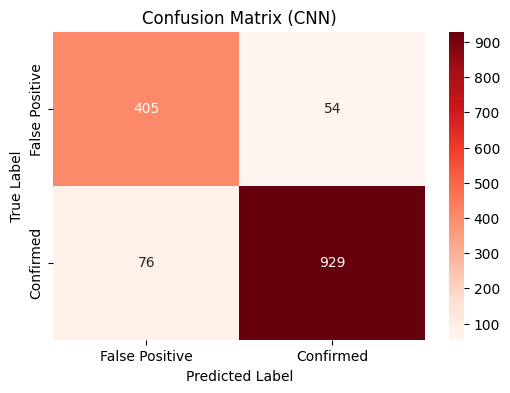

In [44]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds",
            xticklabels=['False Positive', 'Confirmed'],
            yticklabels=['False Positive', 'Confirmed'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (CNN)")
plt.show()

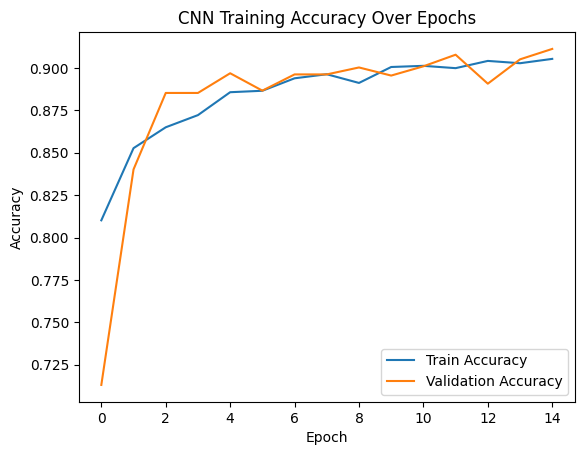

In [45]:
# Plot Training vs Validation Accuracy
plt.plot(train.history['accuracy'], label='Train Accuracy')
plt.plot(train.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')  # X-axis: Epoch number
plt.ylabel('Accuracy')  # Y-axis: Accuracy percentage
plt.legend()  # Show legend
plt.title('CNN Training Accuracy Over Epochs')  # Title of the plot
plt.show()  # Display the plot

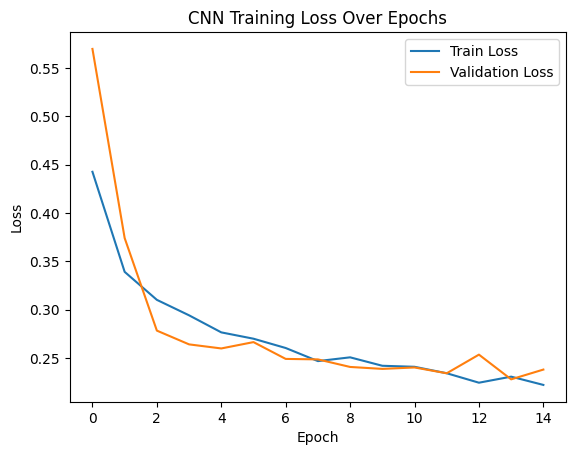

In [46]:
# Plot Training vs Validation Loss
plt.plot(train.history['loss'], label='Train Loss')
plt.plot(train.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')  # X-axis: Epoch number
plt.ylabel('Loss')  # Y-axis: Loss value
plt.legend()  # Show legend
plt.title('CNN Training Loss Over Epochs')  # Title of the plot
plt.show()  # Display the plot

##MLP

The second input will use PCA to create tabular data and use an MLP model to capture trends in the data.

In [ ]:
#Build the MLP

#Test/Train Split
x = features
y = target_vector

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

# standardized_df = pd.DataFrame(standardized_features, columns=features.columns)
original_dim = X_train.shape[1]

###Adding PCA

Before passing the features to an MLP model, we will perform intrinsic dimensionality reduction (IDR) using PCA.

In [ ]:
#initial PCA run on all components to calc
pca = PCA(n_components=original_dim)
reduced_features = pca.fit_transform(X_train)

reduced_dim = reduced_features.shape[1]

In [ ]:
explained_variance_ratio = pca.explained_variance_ratio_

cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)
explained_variance = pca.explained_variance_

num_components = []
cumulative_variances = []
cumulative_ratio = []

for i in range(1, original_dim + 1):
    num_components.append(i)

    cumulative_variances.append(float(np.sum(explained_variance[:i])))
    cumulative_ratio.append(float(cumulative_explained_variance_ratio[i - 1]))

In [ ]:
#calc elbow/knee
kl = KneeLocator(num_components, cumulative_ratio, curve="concave", direction="increasing", online=True)

elbow_point_kl = int(kl.elbow)
elbow_point_kl

In [ ]:
kl_pca = PCA(n_components=elbow_point_kl)

X_train_pca = kl_pca.fit_transform(X_train)
X_test_pca = kl_pca.transform(X_test)

print(f"Train shape: {X_train_pca.shape}")
print(f"Test shape: {X_test_pca.shape}")

###Model

In [ ]:
#Creating the MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)

# Make predictions on the test data
y_pred = mlp.predict(X_test)

In [ ]:
#Now with PCA :pp
mlp_pca = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
mlp_pca.fit(X_train_pca, y_train)

y_pred_pca = mlp_pca.predict(X_test_pca)

###Evaluation

In [ ]:
# Evaluating the model WITHOUT PCA
print("MLP Model without PCA:")
accuracy = accuracy_score(y_test, y_pred) #og
print(f"Accuracy: {accuracy:.2f}")

class_report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(class_report).transpose()

print("Classification Report")
display(report_df.style.format("{:.2f}"))

In [ ]:
# PCAaaa
print("MLP Model with PCA:")
pca_accuracy = accuracy_score(y_test, y_pred_pca)
print(f"Accuracy: {pca_accuracy:.2f}")

pca_class_report = classification_report(y_test, y_pred_pca, output_dict=True)
pca_report_df = pd.DataFrame(pca_class_report).transpose()

print("Classification Report")
display(pca_report_df.style.format("{:.2f}"))

In [ ]:
# Confusion Matrix of labels withOUT PCA
c_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(c_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Confirmed', 'False Positive'],
            yticklabels=['Confirmed', 'False Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (MLP)')
plt.show()

In [ ]:
# Confusion Matrix of labels with PCA
pca_matrix = confusion_matrix(y_test, y_pred_pca)

plt.figure(figsize=(7, 5))
sns.heatmap(pca_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Confirmed', 'False Positive'],
            yticklabels=['Confirmed', 'False Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (PCA Model)')
plt.show()

##Sources

Dataset:

https://www.kaggle.com/datasets/nasa/kepler-exoplanet-search-results/data

1D CNN:

https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D
https://quickdrew.github.io/AndysNotes/ai/pages/1d_cnn/
MLP:

https://www.geeksforgeeks.org/machine-learning/classification-using-sklearn-multi-layer-perceptron/
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html